In [1]:
%matplotlib inline
from collections import defaultdict

import matplotlib.pylab as plt
from skimpy import skim
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import seaborn as sns

from tqdm import tqdm

from pathlib import Path


In [2]:

import tensorflow as tf
import tensorflow_probability as tfp

from bayesianquilts.models.logistic_regression import LogisticRegression
from bayesianquilts.models.logistic_regression_reparam import LogisticRegression2

from bayesianquilts.metrics.classification import classification_metrics
from bayesianquilts.sampler import psis, nppsis

2024-02-08 03:48:13.260341: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-08 03:48:13.298035: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-08 03:48:13.298077: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-08 03:48:13.299497: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-08 03:48:13.306137: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-08 03:48:13.306590: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
print(tf.__version__, tfp.__version__)

2.15.0 0.23.0


# Load the dataset

Using the example from here: https://www.tensorflow.org/guide/core/logistic_regression_core

In [4]:
from ucimlrepo import fetch_ucirepo 


In [5]:
use_saved = False

cdc_diabetes_health_indicators = fetch_ucirepo(id=891) 


# data (as pandas dataframes) 
batch_size=128
X_ = cdc_diabetes_health_indicators.data.features[:batch_size*1000]
y_ = cdc_diabetes_health_indicators.data.targets[:batch_size*1000]

X_ = X_.fillna(0)

X_scaled = (X_ - X_.mean())/X_.std()
X_scaled = X_scaled.fillna(0)
n = X_scaled.shape[0]
p = X_scaled.shape[1]

print((n, p))


(128000, 21)


In [6]:
X_.columns

Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

In [7]:
n_outliers = 1
ndx = np.abs(X_scaled[['HighBP', 'Age',"DiffWalk"]]).sum(axis=1).sort_values(ascending=False)[:n_outliers].index
outliers = X_scaled.loc[ndx]
outliers

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
127530,1.151445,1.159334,0.194288,0.506774,1.110418,-0.2073,-0.320922,-1.78214,0.75337,0.482402,...,0.224735,3.346593,-0.47076,0.522648,0.320183,2.241884,1.129615,-2.310598,-1.102525,-1.022175


In [8]:
outliers_y = y_.loc[ndx]
outliers_y

,Diabetes_binary
127530,0


In [9]:
outliers[['HighBP', 'HighChol', 'BMI', 'Stroke',
       'HeartDiseaseorAttack', 'NoDocbcCost', 
       'Age', 'Education',
       'Income']] *= -10

outliers

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
127530,-11.514446,-11.593335,0.194288,-5.067738,1.110418,2.073004,3.209222,-1.78214,0.75337,0.482402,...,0.224735,-33.465929,-0.47076,0.522648,0.320183,2.241884,1.129615,23.105976,11.025248,10.22175


In [10]:
X_scaled = pd.concat([outliers, X_scaled], axis=0)
y_ = pd.concat([outliers_y, y_], axis=0)

In [11]:
X_scaled = (X_scaled - X_scaled.mean())/X_scaled.std()
X_scaled = X_scaled.fillna(0)
n = X_scaled.shape[0]
p = X_scaled.shape[1]

print((n, p))


(128001, 21)


In [12]:


tfdata = tf.data.Dataset.from_tensor_slices({'X': X_scaled, 'y':y_})

def data_factory_factory(batch_size=batch_size, repeat=False, shuffle=False, omit_outlier=False):
    if omit_outlier:
        tfdata_ = tfdata.skip(n_outliers)
    else:
        tfdata_ = tfdata
    def data_factory(batch_size=batch_size):
        if shuffle:
            out = tfdata_.shuffle(batch_size*10)
        else:
            out = tfdata_
        
        if repeat:
            out = out.repeat()
        return out.batch(batch_size)
    return data_factory

Instantiate the model object

In [13]:
if not use_saved:
    lr_model = LogisticRegression2(dim_regressors=p)
        
else:
    import dill as pickle
    import gzip
    with gzip.open("breast.gz", 'rb') as f:
        lr_model = pickle.load(f)

Set up Bayesian minibatch ADVI inference

In [14]:
if not use_saved:

    losses = lr_model.fit(
        data_factory_factory(shuffle=True, repeat=True, omit_outlier=True),
        dataset_size=n,
        batches_per_step=20,
        check_every=int(n/batch_size),
        batch_size=batch_size,
        num_steps=6000,
        max_decay_steps=20,
        max_plateau_epochs=20,
        sample_size=32,
        learning_rate=0.0005)
        

    lr_model.save("diabetes")


Running optimization for 6000 steps of 20 accumulated batches, checking every 1000 steps
Saved a checkpoint: /tmp/tfcheckpoints/c56f535c-8312-4601-8cc5-7272f7d0b065/c56f535c-8312-4601-8cc5-7272f7d0b065-1


  0%|          | 0/6000 [00:00<?, ?it/s]

ValueError: Dimensions must be equal, but are 32 and 128 for '{{node mul_5}} = Mul[T=DT_DOUBLE](mul_4, strided_slice)' with input shapes: [32,21], [1,128,21].

In [15]:
def prediction_fn(data):
    params = lr_model.sample(128)
    pred = lr_model.predictive_distribution(data, **params)["logits"]
    return tf.reduce_mean(pred, axis=0)

bench = classification_metrics(
    data_factory=data_factory_factory(),
    prediction_fn=prediction_fn,
    outcome_label='y',
    by_vars=[]
)

fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(bench['auroc']['fpr'], bench['auroc']['tpr'])
ax[0].text(0.5, 0.1, f"AUROC: {round(bench['auroc']['auroc'], 2)}")
ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(bench['auprc']['recall'], bench['auprc']['precision'])
ax[1].text(0.5, 0.8, f"AUPRC: {round(bench['auprc']['auprc'], 2)}")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))

0it [00:00, ?it/s]

1001it [01:18, 12.75it/s]


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1000 has 0 dimension(s)

In [ ]:
test_batch = next(iter(data_factory_factory()()))
param_test = lr_model.sample(128)


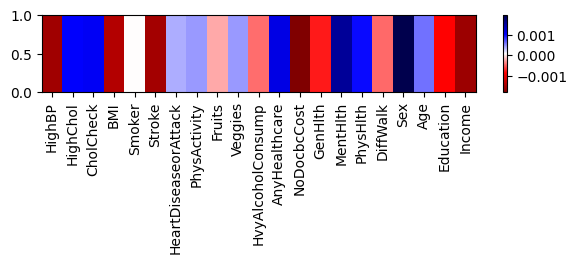

In [ ]:
beta = tf.reduce_mean(param_test['beta__'], axis=0)
fig, ax = plt.subplots(1, 1, figsize=(7, 1 ))
im = ax.pcolormesh(beta, cmap='seismic_r')
_ = ax.set_xticks(0.5 + np.arange(len(X_.columns)), X_.columns, rotation=90)
plt.colorbar(im)

In [ ]:
def entropy(probs):
    return -tf.math.xlogy(probs, probs)


def adaptive_is_loo(self, data, params, hbar=1.0, variational=True):
    """_summary_

    Args:
        data (_type_): _description_
        params (_type_): _description_
        hbar (float, optional): _description_. Defaults to 1.0.
        variational (bool, optional):
            Should we trust the variational approximation?
            If False, assumes that one is passing in all the data at once in a single batch.
            Defaults to True.

    Returns:
        _type_: _description_
    """

    # scaled (theta - bar(theta))/Sigma
    beta = params["beta__"]
    intercept = params["intercept__"]
    X = tf.cast(data["X"], self.dtype)
    y = tf.cast(data["y"], self.dtype)[:, 0]
    mu = tf.reduce_sum(beta * X, axis=-1) + intercept[..., 0]
    sigma = tf.math.sigmoid(mu)
    ell = y * (sigma) + (1 - y) * (1 - sigma)
    log_ell = tf.math.xlogy(y, sigma) + tf.math.xlogy(1 - y, 1 - sigma)
    log_ell_prime = y * (1 - sigma) - (1 - y) * sigma
    log_ell_doubleprime = -sigma * (1 - sigma)

    """
    sigma.shape is samples x datapoints
    """

    # compute # \nabla\log\pi(\btheta|\calD)
    if variational:
        # \nabla\log\pi = -\Sigma^{-1}(theta - \bar{\theta})
        grad_log_pi = tf.concat(
            [
                -(intercept - self.surrogate_distribution.model["intercept__"].mean())
                / self.surrogate_distribution.model["intercept__"].variance(),
                -(beta - self.surrogate_distribution.model["beta__"].mean())
                / self.surrogate_distribution.model["beta__"].variance(),
            ],
            axis=-1,
        )
        intercept_sd = (
            self.surrogate_distribution.model["intercept__"].variance() ** 0.5
        )
        beta_sd = self.surrogate_distribution.model["beta__"].variance() ** 0.5

        log_pi = self.surrogate_distribution.model["beta__"].log_prob(
            params["beta__"]
        ) + self.surrogate_distribution.model["intercept__"].log_prob(
            params["intercept__"]
        )
        log_pi -= tf.reduce_max(log_pi, axis=0)
        # log_pi.shape: [samples]
    else:
        """
        Recall Bayes rule:
        \log pi(\btheta|\calD) = \sum_i\log ell_i(\btheta) + \log\pi(\btheta) + const

        so
        \nabla\log\pi(\btheta|\calD) = \sum_i (ell_i)'x + grad\log\pi(\btheta)

        """
        log_pi = tf.reduce_sum(log_ell, axis=1, keepdims=True)[:, 0]
        log_pi += self.prior_distribution.log_prob(
            {
                "regression_model": {
                    k: tf.cast(params[k], self.dtype) for k in self.regression_var_list
                },
                "intercept_model": {
                    k: tf.cast(params[k], self.dtype) for k in self.intercept_var_list
                },
            }
        )
        # pi \propto
        grad_log_pi = tf.reduce_sum(
            log_ell[..., tf.newaxis] * X, axis=1, keepdims=True
        )  # TODO NEED PRIOR TERM

        prior_intercept_sd = (
            self.prior_distribution.model["intercept_model"]
            .model["intercept__"]
            .variance()
            ** 0.5
        )
        prior_beta_sd = params["global_scale"]

        intercept_sd = tf.math.reduce_std(intercept, 0, keepdims=True)
        beta_sd = tf.math.reduce_std(beta, 0, keepdims=True)

    # log-likelihood descent

    def T_ll():
        Q_beta = -log_ell_prime[..., tf.newaxis] * X
        Q_intercept = -log_ell_prime[..., tf.newaxis]

        standardized = tf.concat(
            [Q_beta / beta_sd, Q_intercept / intercept_sd], axis=-1
        )
        standardized = tf.reduce_max(tf.math.abs(standardized), axis=-1)
        standardized = tf.reduce_max(standardized, axis=0, keepdims=True)[
            ..., tf.newaxis
        ]

        h = hbar / standardized
        logJ = tf.math.log1p(
            tf.math.abs(
                h
                * (1 + tf.math.reduce_sum(X**2, -1, keepdims=True))[tf.newaxis, :, :]
                * (sigma * (1 - sigma))[..., tf.newaxis]
            )[..., 0]
        )
        beta_ll = beta + h * Q_beta
        intercept_ll = intercept + h * Q_intercept
        return beta_ll, intercept_ll, logJ

    def T_kl():

        Q_beta = ((-1) ** y * tf.math.exp(log_pi[..., tf.newaxis] + mu * (1 - 2 * y)))[
            ..., tf.newaxis
        ] * data["X"]
        Q_intercept = (
            (-1) ** y * tf.math.exp(log_pi[..., tf.newaxis] + mu * (1 - 2 * y))
        )[..., tf.newaxis]

        dQ = (
            (-1) ** y[tf.newaxis, :]
            * tf.math.exp(log_pi[..., tf.newaxis] + mu * (1 - 2 * y[tf.newaxis, :]))
            * (
                grad_log_pi[..., 0]
                + (1 - 2 * y)[tf.newaxis, :]
                + tf.reduce_sum(
                    X * (grad_log_pi[..., 1:] + (1 - 2 * y)[:, tf.newaxis] * X), axis=-1
                )
            )
        )

        standardized = tf.concat(
            [Q_beta / beta_sd, Q_intercept / intercept_sd], axis=-1
        )
        standardized = tf.reduce_max(tf.math.abs(standardized), axis=-1)
        standardized = tf.reduce_max(standardized, axis=0, keepdims=True)[
            ..., tf.newaxis
        ]

        h = hbar / standardized

        intercept_kl = intercept + h * Q_intercept
        beta_kl = beta + h * Q_beta

        logJ = tf.math.log1p(tf.math.abs(h[..., 0] * dQ))
        return beta_kl, intercept_kl, logJ

    # variance descent -(log ell)'/l

    def T_I():
        Q = tf.zeros_like(log_ell)
        return (
            beta + Q[..., tf.newaxis],
            intercept + Q[..., tf.newaxis],
            tf.zeros_like(Q),
        )

    def T_var():

        Q_beta = (
            (-1) ** y * tf.math.exp(log_pi[..., tf.newaxis] + 2 * mu * (1 - 2 * y))
        )[..., tf.newaxis] * data["X"]
        Q_intercept = (
            (-1) ** y * tf.math.exp(log_pi[..., tf.newaxis] + 2 * mu * (1 - 2 * y))
        )[..., tf.newaxis]

        dQ = (
            (-1) ** y[tf.newaxis, :]
            * tf.math.exp(log_pi[..., tf.newaxis] + 2 * mu * (1 - 2 * y[tf.newaxis, :]))
            * (
                grad_log_pi[..., 0]
                + (1 - 2 * y)[tf.newaxis, :]
                + tf.reduce_sum(
                    X * (grad_log_pi[..., 1:] + 2 * (1 - 2 * y)[:, tf.newaxis] * X),
                    axis=-1,
                )
            )
        )

        standardized = tf.concat(
            [Q_beta / beta_sd, Q_intercept / intercept_sd], axis=-1
        )
        standardized = tf.reduce_max(tf.math.abs(standardized), axis=-1)
        standardized = tf.reduce_max(standardized, axis=0, keepdims=True)[
            ..., tf.newaxis
        ]

        h = hbar / standardized

        intercept_kl = intercept + h * Q_intercept
        beta_kl = beta + h * Q_beta

        logJ = tf.math.log1p(tf.math.abs(h[..., 0] * dQ))
        return beta_kl, intercept_kl, logJ

    def IS(Q):
        beta_new, intercept_new, logJ = Q()
        mu_new = tf.reduce_sum(beta_new * X, axis=-1) + intercept_new[..., 0]
        sigma_new = tf.math.sigmoid(mu_new)
        ell_new = y * (sigma_new) + (1 - y) * (1 - sigma_new)
        log_ell_new = tf.math.xlogy(y, sigma_new) + tf.math.xlogy(1 - y, 1 - sigma_new)
        transformed = params.copy()
        transformed["beta__"] = beta_new[..., tf.newaxis, :]
        transformed["intercept__"] = intercept_new[..., tf.newaxis, :]
        transformed["global_scale"] = transformed["global_scale"][..., tf.newaxis, :]
        transformed["global_scale_aux"] = transformed["global_scale_aux"][
            ..., tf.newaxis, :
        ]

        if variational:
            # We trust the variational approximation, so \hat{pi} = pi
            # N_samples x N_data
            delta_log_pi = (
                self.surrogate_distribution.log_prob(transformed)
                - log_pi[:, tf.newaxis]
            )
            delta_log_pi = delta_log_pi - tf.reduce_max(
                delta_log_pi, axis=0, keepdims=True
            )
            pass
        else:
            # we don't trust the variational approximation
            # Need to compute log_pi directly by summing over the likelihood

            ell_cross = (
                tf.reduce_sum(beta_new[..., tf.newaxis, :] * data["X"], -1)
                + intercept_new
            )
            ell_cross = tf.reduce_sum(
                ell_cross, -1
            )  # this is the likelihood portion of pi(T(theta))

            log_pi_new = self.prior_distribution.log_prob(
                {
                    "regression_model": {
                        k: tf.cast(transformed[k], self.dtype)
                        for k in self.regression_var_list
                    },
                    "intercept_model": {
                        k: tf.cast(transformed[k], self.dtype)
                        for k in self.intercept_var_list
                    },
                }
            )[:, tf.newaxis]
            log_pi_new += ell_cross
            log_pi_old = self.surrogate_distribution.log_prob(params)
            # Incorporate the prior
            delta_log_pi = log_pi_new - log_pi_old[:, tf.newaxis]
            delta_log_pi = delta_log_pi - tf.reduce_max(
                delta_log_pi, axis=0, keepdims=True
            )

        log_eta_weights = delta_log_pi - log_ell_new + logJ
        psis_weights, khat = nppsis.psislw(log_eta_weights)
        
        eta_weights = tf.math.exp(log_eta_weights)
        eta_weights = eta_weights / tf.reduce_sum(eta_weights, axis=0, keepdims=True)

        psis_weights = tf.math.exp(psis_weights)
        psis_weights = psis_weights / tf.math.reduce_sum(
            psis_weights, axis=0, keepdims=True
        )

        weight_entropy = self.entropy(eta_weights)
        psis_entropy = self.entropy(psis_weights)

        p_loo_new = tf.reduce_sum(sigma_new * eta_weights, axis=0)
        p_loo_psis = tf.reduce_sum(sigma_new * psis_weights, axis=0)
        p_loo_sd = tf.math.reduce_std(sigma_new * eta_weights, axis=0)
        ll_loo_new = tf.reduce_sum(eta_weights * ell_new, axis=0)
        ll_loo_psis = tf.reduce_sum(psis_weights * ell_new, axis=0)
        ll_loo_sd = tf.math.reduce_std(eta_weights * ell_new, axis=0)
        return (
            eta_weights,
            psis_weights,
            p_loo_new,
            p_loo_sd,
            ll_loo_new,
            ll_loo_sd,
            weight_entropy,
            khat,
            p_loo_psis,
            ll_loo_psis,
        )
    (
        eta_I,
        eta_I_psis,
        p_loo_I,
        p_loo_I_sd,
        ll_loo_I,
        ll_loo_I_sd,
        S_I,
        k_I,
        p_psis_I,
        ll_psis_I,
    ) = IS(T_I)
    (
        eta_ll,
        eta_ll_psis,
        p_loo_ll,
        p_loo_ll_sd,
        ll_loo_ll,
        ll_loo_ll_sd,
        S_ll,
        k_ll,
        p_psis_ll,
        ll_psis_ll,
    ) = IS(T_ll)

    (
        eta_kl,
        eta_kl_psis,
        p_loo_kl,
        p_loo_kl_sd,
        ll_loo_kl,
        ll_loo_kl_sd,
        S_kl,
        k_kl,
        p_psis_kl,
        ll_psis_kl,
    ) = IS(T_kl)

    (
        eta_var,
        eta_var_psis,
        p_loo_var,
        p_loo_var_sd,
        ll_loo_var,
        ll_loo_var_sd,
        S_var,
        k_var,
        p_psis_var,
        ll_psis_var,
    ) = IS(T_var)

    # kl descent

    return {
        "I": {
            "p_loo": p_loo_I,
            "p_loo_sd": p_loo_I_sd,
            "ll_loo": ll_loo_I,
            "ll_loo_sd": ll_loo_I_sd,
            "S": S_I,
            "khat": k_I,
            "p_psis": p_psis_I,
            "ll_psis": ll_psis_I,
        },
        "KL": {
            "p_loo": p_loo_kl,
            "p_loo_sd": p_loo_kl_sd,
            "ll_loo": ll_loo_kl,
            "ll_loo_sd": ll_loo_kl_sd,
            "S": S_kl,
            "khat": k_kl,
            "p_psis": p_psis_kl,
            "ll_psis": ll_psis_kl,
        },
        "LL": {
            "p_loo": p_loo_kl,
            "p_loo_sd": p_loo_kl_sd,
            "ll_loo": ll_loo_kl,
            "ll_loo_sd": ll_loo_kl_sd,
            "S": S_ll,
            "khat": k_ll,
            "p_psis": p_psis_ll,
            "ll_psis": ll_psis_ll,
        },
        "Var": {
            "p_loo": p_loo_var,
            "p_loo_sd": p_loo_var_sd,
            "ll_loo": ll_loo_var,
            "ll_loo_sd": ll_loo_var_sd,
            "S": S_var,
            "khat": k_var,
            "p_psis": p_psis_var,
            "ll_psis": ll_psis_var,
        },
    }


param_test = lr_model.sample(256)

loo = adaptive_is_loo(lr_model, test_batch, param_test, 1., variational=True)

# loo = adaptive_is_loo(lr_model, test_batch, param_test, 0.01, variational=False)


for T in ["I", "LL", "KL", "Var"]:
    print(
        f"{T}: {np.sqrt(np.sum(loo[T]['p_loo_sd']**2))} entropy: {np.sqrt(np.sum(loo[T]['S']))} khat>0.5: {np.sum(loo[T]['khat']>0.5)}"
    )

I: 0.010800396641628542 entropy: 25.064170753278198 khat>0.5: 0
LL: 0.0117818149574106 entropy: 22.15398336437576 khat>0.5: 88
KL: 0.0117818149574106 entropy: 24.963409687143496 khat>0.5: 0
Var: 0.011773132325698004 entropy: 24.96410382811141 khat>0.5: 0


In [ ]:
loo['I']['khat']

array([-0.38360719, -0.3366498 , -0.09147351, -0.46308591, -0.46164129,
       -0.4631648 , -0.46338338, -0.46322904, -0.45611439, -0.46269072,
       -0.46355763, -0.44720727, -0.46537298, -0.47336659, -0.4582852 ,
       -0.4617715 , -0.4646178 , -0.45840417, -0.46647197, -0.4637153 ,
       -0.48268654, -0.46309451, -0.46635706, -0.46249215, -0.45803209,
       -0.46076229, -0.49204473, -0.4608339 , -0.46303152, -0.44760817,
       -0.45636867, -0.46064504, -0.4560904 , -0.48339656, -0.46231431,
       -0.46299921, -0.46510051, -0.48331022, -0.46344042, -0.46080898,
       -0.46229899, -0.45881087, -0.45564762, -0.46375812, -0.48408271,
       -0.4575559 , -0.46149264, -0.45941096, -0.46243295, -0.46534056,
       -0.45468591, -0.46108092, -0.48548817, -0.46079575, -0.45965428,
       -0.47337742, -0.46625113, -0.46254619, -0.46249486, -0.46379081,
       -0.45856293, -0.45721323, -0.46234579, -0.48716158, -0.46482762,
       -0.45930243, -0.46658623, -0.46117797, -0.45480915, -0.45

# Compute LOO AU ROC/PRC

In [ ]:
step_size = 0.2
def prediction_fn_stepaway(data):
    params = lr_model.sample(100)
    loo = adaptive_is_loo(lr_model, data, params, step_size)
    return loo["KL"]['p_psis']

def prediction_fn_loo(data):
    params = lr_model.sample(100)
    pred = adaptive_is_loo(lr_model, data, params, step_size)["I"]['p_psis']
    return pred



In [ ]:
bench_stepaway_loo = classification_metrics(
    data_factory=data_factory_factory(batch_size=2000),
    prediction_fn=prediction_fn_stepaway,
    outcome_label='y',
    by_vars=[]
)

bench_loo = classification_metrics(
    data_factory=data_factory_factory(batch_size=2000),
    prediction_fn=prediction_fn_loo,
    outcome_label='y',
    by_vars=[]
)



13it [00:22,  1.75s/it]
13it [00:22,  1.72s/it]


Step-away LOO

(0.0, 1.0)

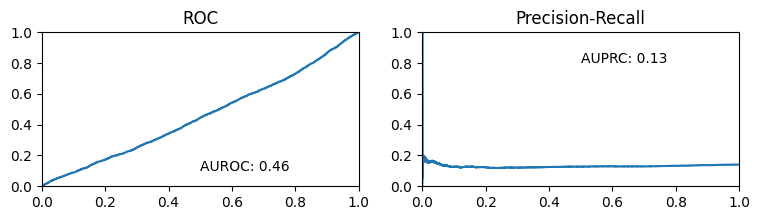

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(bench_stepaway_loo['auroc']['fpr'], bench_stepaway_loo['auroc']['tpr'])
ax[0].text(0.5, 0.1, f"AUROC: {round(bench_stepaway_loo['auroc']['auroc'], 2)}")
ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(bench_stepaway_loo['auprc']['recall'], bench_stepaway_loo['auprc']['precision'])
ax[1].text(0.5, 0.8, f"AUPRC: {round(bench_stepaway_loo['auprc']['auprc'], 2)}")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))

LOO w/o stepaway

(0.0, 1.0)

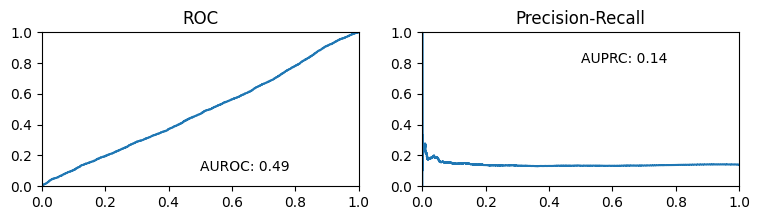

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(bench_loo['auroc']['fpr'], bench_loo['auroc']['tpr'])
ax[0].text(0.5, 0.1, f"AUROC: {round(bench_loo['auroc']['auroc'], 2)}")
ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(bench_loo['auprc']['recall'], bench_loo['auprc']['precision'])
ax[1].text(0.5, 0.8, f"AUPRC: {round(bench_loo['auprc']['auprc'], 2)}")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))

Training data metrics

In [ ]:
bench['auroc']['auroc']

0.49432691215890473

In [ ]:
params = lr_model.sample(200)
loo_out = []
for batch in tqdm(iter(data_factory_factory(batch_size=1000, repeat=False)())):
    loo_out += [adaptive_is_loo(lr_model, batch, params, 0.5, variational=True)]

0it [00:00, ?it/s]

26it [00:31,  1.22s/it]


In [ ]:
loo_out[0].keys()

dict_keys(['I', 'KL', 'LL', 'Var'])

In [ ]:
khat = {}
p_loo = {}
for method in ["I", "LL", "KL", "Var"]:
    khat[method] = np.concatenate([out[method]["khat"] for out in loo_out], axis=0)
    p_loo[method] = np.concatenate([out[method]["p_loo"] for out in loo_out], axis=0)

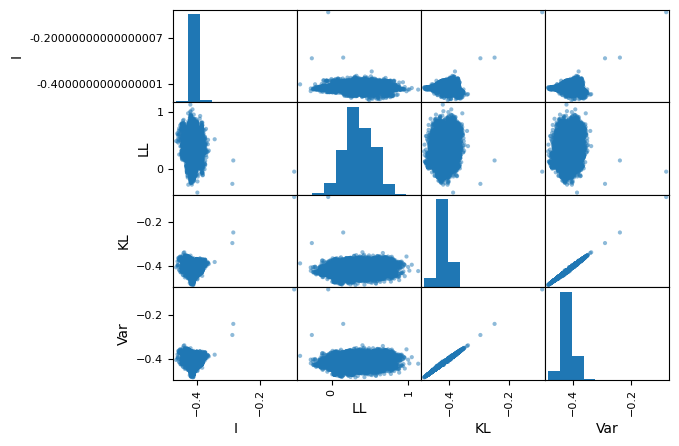

In [ ]:
khat = pd.DataFrame(khat)
_ = pd.plotting.scatter_matrix(khat)


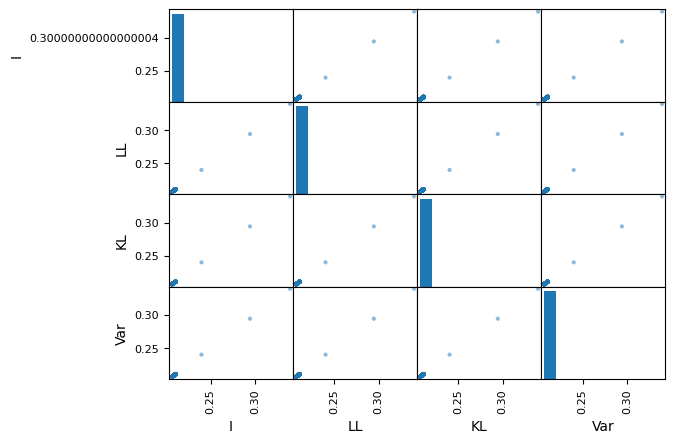

In [ ]:
p_loo = pd.DataFrame(p_loo)
_ = pd.plotting.scatter_matrix(p_loo)

In [ ]:
khat.describe()

,I,LL,KL,Var
count,25603.000000,25603.000000,25603.000000,25603.000000
mean,-0.415910,0.352778,-0.421031,-0.421438
std,0.008193,0.185918,0.018959,0.019119
min,-0.467905,-0.411758,-0.484327,-0.485928
25%,-0.420307,0.224020,-0.434526,-0.435084
50%,-0.416587,0.341794,-0.423728,-0.424109
75%,-0.412974,0.488785,-0.408362,-0.408713
max,-0.089841,1.126701,-0.089777,-0.080689


In [ ]:
khat[khat.I > 0.5]

,I,LL,KL,Var


In [ ]:
(khat>0.5).describe()

,I,LL,KL,Var
count,25603,25603,25603,25603
unique,1,2,1,1
top,False,False,False,False
freq,25603,19616,25603,25603
